# Churn within the Realm of Telecom

## Project Goals

- Discovers the biggest drivers of customer churn.  

- Use those drivers to develope machine learning models to accurately classify customers as either churned or not churned.

- Deliver a report that a non-techincal person can read and understand what steps were taken, why they were taken, and the outcomes from those steps.

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import acquire
import prepare
import modeling

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

seed = 42

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns = None

# Acquire

- I obtained my data from the Codeup MySQL server, though this dataset is available online

- I got my data on 1/2/23

- The dataset is 7043 rows by 25 columns

- Each observation is an individual customer

- Each row represents something about that customer

In [2]:
#this pulls my data from the .csv file and 
#shows the first row, to get a feel for the columns
data = acquire.get_telco_data()

data.head(1)

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check


# Prepare

- After acquiring my data, the first thing I did was to replace empty spaces in the 'total_charges' column with zeroes, so that I could convert the data type to float.

- After that, I checked to see if there were any null values, or anything that might of significance that could skew my results. After performing some lines of code, I determined that there weren't any outliers of enough significance to drop them. I didn't run into any nulls.

- After that, I made dummy columns for all of my categorical columns to convert them into useful, numeric values. With a couple of the columns, like the 'multiple_lines' column, it created a dummy that wasn't helpful, called 'multiple_lines_No phone service', so I manually dropped those and then cleared out all of the columns that the dummies originated from, and concatenated the dummies together with the cleaned dataframe.

In [3]:
#this uses my function to clean the data and 
#shows the first row to compare to the uncleaned dataframe
data = prepare.prep_telco(data)

data.head(1)

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,contract_type,internet_service_type,churn_Yes,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0002-ORFBO,0,9,65.6,593.3,One year,DSL,0,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1


In [4]:
#this separates my data into my train, validate, and test sets
train, val, test = modeling.split_train_test(data, 'churn_Yes')

In [5]:
#this is simply to confirm that the proportions of the sets look correct
train.shape, val.shape, test.shape

((3521, 30), (2113, 30), (1409, 30))

# Explore

## Is whether or not a customer churns dependent of their internet service type?

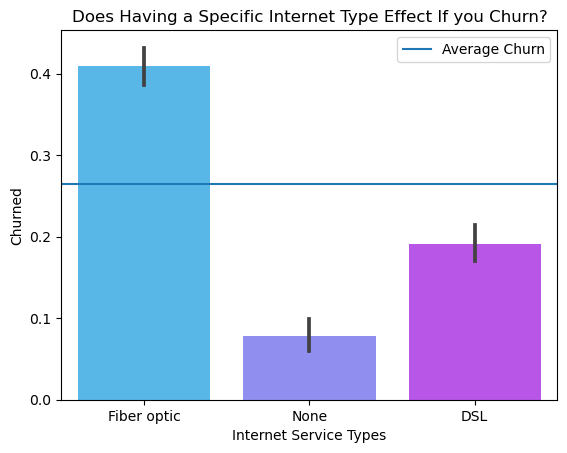

In [6]:
#This block of code creates by bar chart
sns.barplot(x='internet_service_type', y='churn_Yes', 
            data=train, palette='cool')
#I'm creating a line that goes across the chart that shows the average
churn_rate = train.churn_Yes.mean()
plt.axhline(churn_rate, label="Average Churn")

#creating labels and a title
plt.title('Does Having a Specific Internet Type Effect If you Churn?')
plt.xlabel('Internet Service Types')
plt.ylabel('Churned')

#making sure the legend appears
plt.legend()
plt.show()

- The main takeaway here is that it really looks as if there is a realtionship between churn and internet service type.

- The other point to note is that this might indicate there are improvements that can be made for the fiber optic customers.

For this question, I decided it would be useful to dig deeper and perform a statistical test to help back up my assumptions. Since we are talking about two categorical variables here, I used a chi-square test to determine if there was a relationship.

My $H_a$ here is that there is **no** significant relationship between churn and internet service types.

My $H_o$ is that there **is** a relationship of significance.

In [7]:
#function I wrote to return chi^2 test results
prepare.chi2_report(train, 'internet_service_type', 'churn_Yes')

Observed Values

[[972 230]
 [933 646]
 [682  58]]
---
Expected Values

[[ 883  318]
 [1160  418]
 [ 543  196]]
---

chi^2 = 333.9626
p     = 0.0000
Is p-value < alpha? True


So in this test, my p-value is extremely low, which indicates thats its highly likely that there **is** a significant relationship between churn and internet service type. Thus, with this, we can reject our null hypothesis. This would make this an excellent driver for churn to use in our modeling.

## What is the relationship between phone service and churn?

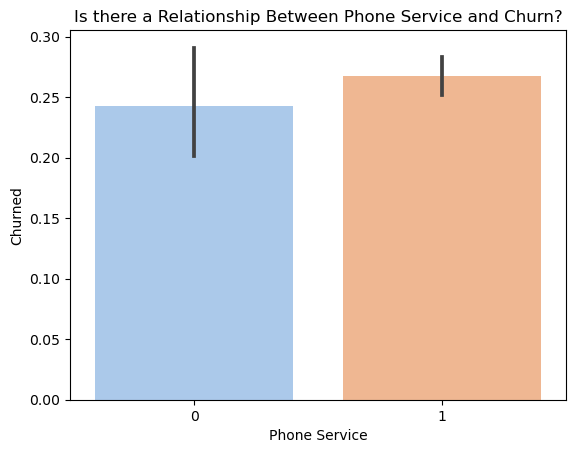

In [8]:
#code to create the barplot
sns.barplot(x='phone_service_Yes', 
            y='churn_Yes', data=train,
            palette='pastel')

#creating labels and a title
plt.title('Is there a Relationship Between Phone Service and Churn?')
plt.xlabel('Phone Service')
plt.ylabel('Churned')

plt.show()

- The number of customers who had phone service and churned compared to the number who didn't have phone service and churned is close enough that I decided to move on to my next question.

- Because there appears to be no real significance, this wouldn't make a good driver for our models.

## Do monthly charges differ for different contract types?

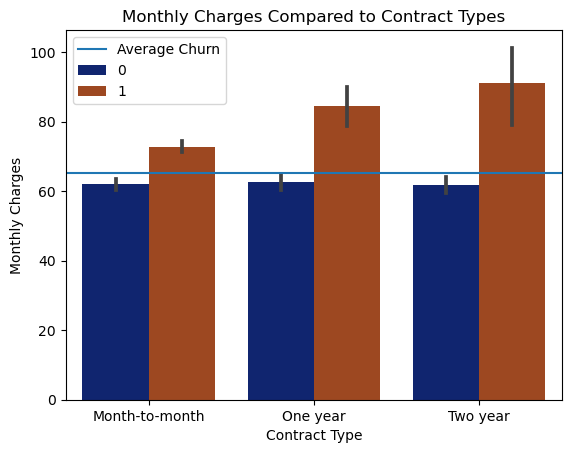

In [9]:
#creating the plot
sns.barplot(x='contract_type', y='monthly_charges',
            hue='churn_Yes', data=train, palette='dark')

#I'm creating a line that goes across the chart that shows the average monthly charges
churn_rate = train.monthly_charges.mean()
plt.axhline(churn_rate, label="Average Churn")

#creating labels and the title
plt.title('Monthly Charges Compared to Contract Types')
plt.xlabel('Contract Type')
plt.ylabel('Monthly Charges')

#creating the legend and showing the visual
plt.legend()
plt.show()

- My main takeaway from this visual is that, generally, if someones bill increases from the average, they are more likely to churn.

- This is exactly what I would have expected, and decided not to dig deeper, but to make sure I use this data with my models.

- This feature will be a driver that is worthy of using when it comes to modeling.

## Are contract type and churn status related?

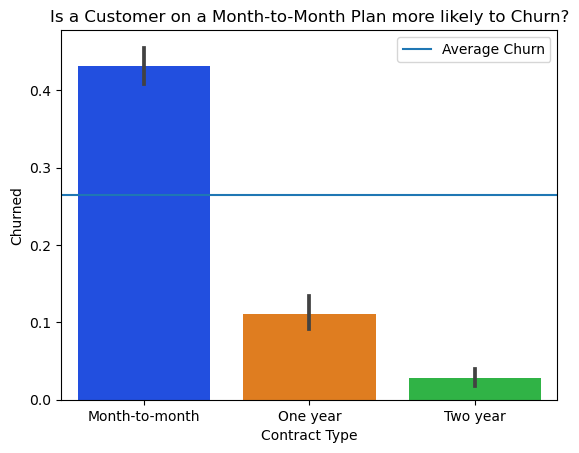

In [10]:
#creating my bar plot
sns.barplot(x='contract_type', y='churn_Yes', 
            data=train, palette='bright')

#creating the average to visualize it as a line across the chart
churn_rate = train.churn_Yes.mean()
plt.axhline(churn_rate, label="Average Churn")

#creating my labels and title
plt.title('Is a Customer on a Month-to-Month Plan more likely to Churn?')
plt.xlabel('Contract Type')
plt.ylabel('Churned')

plt.legend()
plt.show()

- My main takeaway here is that month-to-month customers churn **way** more frequently than other customers.

- It seems very likely there is a relationship here, but to confirm, I performed another statistical test.

### The Statistical test

- Since I am, again, comparing two categorical variables, I used another chi squared test.

My $H_a$ is that there is **no** significant relationship here.

My $H_o$ is the opposite, that there **is**.

In [11]:
#function I wrote to return chi^2 test results
prepare.chi2_report(train, 'contract_type', 'churn_Yes')

Observed Values

[[1089  825]
 [ 679   85]
 [ 819   24]]
---
Expected Values

[[1406  507]
 [ 561  202]
 [ 619  223]]
---

chi^2 = 605.3651
p     = 0.0000
Is p-value < alpha? True


As with my earlier test, my alpha value to compare to is 0.05. 

For this test, when comparing the generated p-value to my alpha, it ends up being significantly smaller. This indicates, like above, that there **is** a significant relationship between churn and contract type. This, of course, means that we can reject our null hypothesis. All of this would make contract type a great driver for customer churn.

## Exploration Summary

- One of my two biggest takeaways from my Exploration process here is that there **is** is significant relationship between a customers internet service type and whether or not they churn.

- The other biggest thing is that contract type and churn also have a significant relationship. 

- There looked as if there might be a relationship between monthly charges and churn, but I ultimately decided to come back and run a statistical test if I had time as it seemed minor.

- Otherwise, I determined that age, gender, and phone service really don't have much of a relationship, so those most likely can be safely dropped.

- After considering my options for modeling, I decided that I wanted to get a base accuracy with all of my features and then come back and cut down on them to see if there was a significant difference.

In order to help visualize what I found to be the two most important features, here is a bar plot comparing the two with customers who have and have not churned.

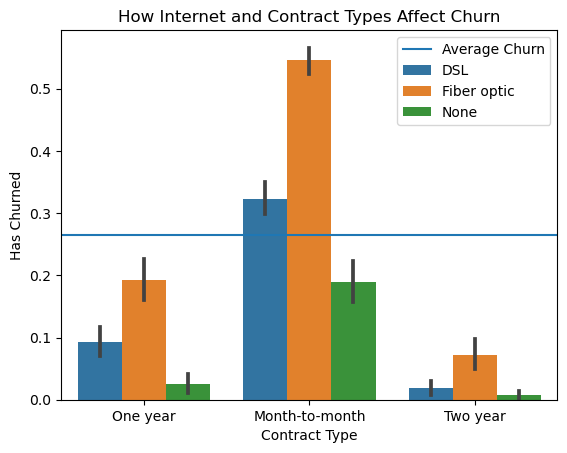

In [12]:
#creating the barplot itself
sns.barplot(x='contract_type',
            y='churn_Yes',
            hue='internet_service_type',
            data=data)

#I'm creating a line that goes across the chart that shows the average
churn_rate = train.churn_Yes.mean()
plt.axhline(churn_rate, label="Average Churn")

#creating labels for each axis and the title 
plt.title("How Internet and Contract Types Affect Churn")
plt.ylabel("Has Churned")
plt.xlabel("Contract Type")

#making the legend and showing the visual
plt.legend()
plt.show()

# Modeling 

- I decided to try each of the four algorithms we've gone over in class to see what fit my data the best. 

- My main evaluation m etric I focused on here was accuracy, but if there were any models that were close to each other, I also factored in my recall. I chose accuracy because I wanted to know how consistently accurate my model was, rather than simply focusing on *when* it was right or wrong.

In [13]:
modeling.make_baseline(data, 'baseline', 'churn_Yes')

Baseline Accuracy is: 0.735


The basline accuracy is made relatively simply. You first need a column in the Dataframe that holds your base prediction for each observation, which you simply do by finding which outcome has happened more, put that in the baseline column.

The second step is to get the number of times you guessed right divided by the number of columns as a whole (the mean).

In this case, my baseline accuracy is 73.4%

In [14]:
X_train, y_train, X_validate, y_validate, X_test, y_test = modeling.xy_train(train, val, test)

## Model #1 Random Forest 

My best model ended up being my second Radnom Forest model

In [15]:
#creating the object
rf = RandomForestClassifier(max_depth=9, 
                            min_samples_leaf=3,
                            n_estimators=200,
                           random_state=42)
#fitting the model
rf.fit(X_train, y_train)

#make the predictions
y_preds2 = rf.predict(X_train)

#obtaining the score for train
train_score2 = rf.score(X_train, y_train)

#obtaining the score for validate
val_score2 = rf.score(X_validate, y_validate)

In [16]:
#printing out my train score and making a new line
print(f'Training Accuracy: {train_score2:.2f}')

print('-----\n')

#printing my validate score
print(f'Validate Accuracy {val_score2:.2f}')

Training Accuracy: 0.85
-----

Validate Accuracy 0.81


## Model #2 Logistic Regression

My second best performing model ended up being my second Logistic Regression model

In [17]:
#creating the object for the model 
logit2 = LogisticRegression(C=.1, random_state=42, 
                           intercept_scaling=1, solver='lbfgs')

#fitting the model
logit2.fit(X_train, y_train)

#making predictions
logit_pred2 = logit2.predict(X_train)

#estimating the probability
logit_pred_proba2 = logit2.predict_proba(X_train)

train_score = logit2.score(X_train, y_train)

val_score = logit2.score(X_validate, y_validate)

In [18]:
#printing out my train score and making a new line
print(f'Training Accuracy: {train_score:.2f}')

print('-----\n')

#printing my validate score
print(f'Validate Accuracy {val_score:.2f}')

Training Accuracy: 0.81
-----

Validate Accuracy 0.81


## Model #3 Decision Tree

My third best was my first Decision Tree model

In [19]:
#creating the model object
clf = DecisionTreeClassifier(max_depth=3, 
                             random_state=42)

#fitting the model
clf = clf.fit(X_train, y_train)

#making train predictions
y_preds3 = clf.predict(X_train)

#obtaining my train score
train_score3 = clf.score(X_train, y_train)

#obtaining my validate score
val_score3 = clf.score(X_train, y_train)

In [20]:
#printing out my train score and making a new line
print(f'Training Accuracy: {train_score3:.2f}')

print('-----\n')

#printing my validate score
print(f'Validate Accuracy {val_score3:.2f}')

Training Accuracy: 0.79
-----

Validate Accuracy 0.79


## Test Model

They are all rather close, but my best model ended up being my second Random Forest model. Its accuracy is the highest of the three, which is the main metric I'm looking at.

Now that I've chosen a model, I will run it on my 'future' unseen data, my train dataset, to see how it performs.

In [21]:
#setting my test score to a variable
test_score = rf.score(X_test, y_test)

#printing my test score
print(f'Test Accuracy {test_score:.2f}')

Test Accuracy 0.79


In order to help illustrate my baseline versus my highest performing model accuracy, I've created two pie charts:

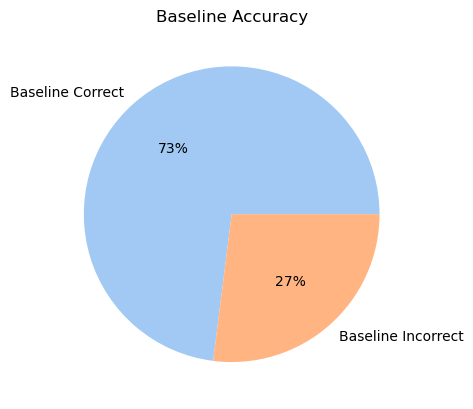

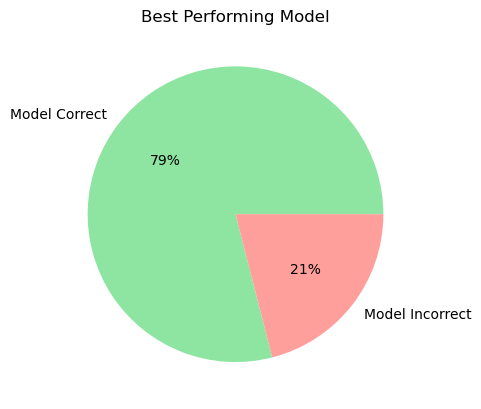

In [22]:
data = [73, 27]
labels = ['Baseline Correct', 'Baseline Incorrect']

colors = sns.color_palette('pastel')[0:2]

plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.title("Baseline Accuracy")
plt.show()

data1 = [79, 21]
labels1 = ['Model Correct', 'Model Incorrect']

colors = sns.color_palette('pastel')[2:4]

plt.pie(data1, labels=labels1, colors=colors, autopct='%.0f%%')
plt.title("Best Performing Model")
plt.show()

## Final Interpretation of the Test

Overall, my best three models are very close, but the test score compares well to my baseline accuracy, beating it by 7%. I **would** recommend this model for production.

# Conclusion

## Summary:

- Gender and Age aren't huge factors when it comes to churn.

- The **biggest** factors appear to be contract type and internet service type. 

- Customers that had fiber optic internet rather than DSL or no internet churned much more, as did customers with month to month contracts over long options.

## Recommendations:

- Provide better support for customers with fiber optic internet.

- Make improvements to month to month contract plans to make it more appealing to customers.

- Alternatively, or in addition to the above, make the one and two year contract types more appealing as customers with those churned significantly less.

- Failing making any significant changes to the month-to-month contracts, maybe sending out emails to those customers most likely to churn, offering a deal or even just sending out surveys would be potentially helpful.

## Next Steps

- As my project stands, if I had more time I would go back to my modeling phase and cut more features to try to see if making less 'noise' improved my accuracy.